In [1]:
#import some things we will need
import pandas as pd
import alipy
import glob
from astropy.io import ascii
from sklearn import linear_model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Gather Photometric Zero Points
On 'Photometric' nights, the observer takes data of Landolt stars. The magnitude of these stars is very will known. We can use the observations of these stars to calibrate the true magnitude of other stars that were observed on the same night.

Eventually, we would like to calibrate the stars we will use as comparison stars in the Nova Musca field. To do this, we will first need the zero points which have been calculated from previous observations of Landolt Stars

In [43]:
suzpts=glob.glob('/home/ih64/Desktop/PhotResults/RESULTS.200[6-9]_*')+glob.glob('/home/ih64/Desktop/PhotResults/RESULTS.201[0-1]_*') + glob.glob('/home/ih64/Desktop/PhotResults/RESULTS.2012_0[0-6]')

rowdict={'date':[], 'star':[], 'b':[], 'v':[],'r':[],'i':[],
	'cb':[],'cv':[],'cr':[],'ci':[],
	'xb':[],'xv':[],'xr':[],'xi':[]}

headerdelim='======================================================================================================================='

for month in suzpts:
	#they're not super machine-readable-friendly, we have to take them apart and yank out what we need
	with open(month,'r') as f:
		text=f.read()

	#header info is in the first two sections above the delimiter
	data=text.split(headerdelim)[2]

	#each date is broken up by a long string of hyphens
	dates=data.split('-----------------------------------------------------------------------------------------------------------------------')

	#go up to the second to last element in the list dates, the last one is just an empty string
	for day in dates[0:-2]:
		words=day.strip().split()
		if words[0][0:2]=='20':
			rowdict['date'].append(float(words[0][2:]))
			rowdict['star'].append(words[1])
			rowdict['b'].append(words[2])
			rowdict['v'].append(words[3])
			rowdict['r'].append(words[4])
			rowdict['i'].append(words[5])
			rowdict['xb'].append(words[6])
			rowdict['xv'].append(words[7])
			rowdict['xr'].append(words[8])
			rowdict['xi'].append(words[9])
			rowdict['cb'].append(words[10])
			rowdict['cv'].append(words[11])
			rowdict['cr'].append(words[12])
			rowdict['ci'].append(words[13])

#shove all the data into a pandas dataframe
table=pd.DataFrame(rowdict)
#force the datatype for the dates to be ints, they were made from strings to floats above
table['date']=table['date'].values.flatten().astype(int)
#the mirror was cleaned on 110921, this note sneaks in and screws up the data frame
table=table.drop(table[table['date']==110921].index)
#suzane filled in the string 'na' if the data was not determined. change these to np NaNs in our dataframe
table=table.replace('na',np.nan)
#sometimes the string '---' was used if the data were not determined, swap these out for nans too
table=table.replace('---',np.nan)
table=table.replace('----',np.nan)
#finally, sometimes 0.0 were used if the data were not determined
table=table.replace(0.0,np.nan)
#foce the datatype for the values to floats, they are currently strings.
table[['b','v','r','i','xb','xv','xr','xi','cb','cv','cr','ci']]=table[['b','v','r','i','xb','xv','xr','xi','cb','cv','cr','ci']].astype(float)
table.to_pickle('suzpts')
table.to_csv('suzpts.csv')

In [64]:
#read in the zero points for a few months from 2012 into pandas data frames
augdeczp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2012-08-12.txt',
                     sep='\s+',skiprows=1,names=['date', 'JulianDate', 'star',
                                      'b', 'v', 'r', 'i',
                                      'xb', 'xv', 'xr', 'xi',
                                      'cb', 'cv', 'cr', 'ci'])

In [65]:
#read in the zero points for different months from 2013 into pandas data frames
#the formatting is different for 2013. But it will be useful to have a mix
#of zero points from both years. Aug-Dec 2012 and Jan-May 2013 use different landolt stars
#using both to calibrate the nova musca field can help avoid any systematic errors
#associated with only 1 landolt field

janzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_01.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

febzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_02.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

marzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_03.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

aprzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_04.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

mayzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_05.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

In [66]:
#now stack all the data frames into one data frame so we have all the data in one place
#doing the inner join gets rid of the 'juliandate' column in the augdec table. the other tables do not have this column

zpts=pd.concat([augdeczp,janzp,febzp,marzp,aprzp,mayzp], join='inner')

#now lets save this table
zpts.to_pickle('zptsTable')

# Align Nova Musca Images
In the I and V directories there are the respective I and V band observations of Nova Musca. We would like to make sure all these images are mutually aligned. This way it will be very easy to do aperature photometry in one shot on all of them.

I got all the Nova Musca images I could get my hands on. Some of them come from the directory /data/yalo180/yalo/SMARTS13m/CCD/ccdNovaMusca and the rest from /net/xrb/ccd/reduced. There are ~200 images for each band at this point. However, I had to go through and inspect images by eye to remove any weird-os. Some look like they have bad flat fielding, poor seeing, bad weather, or other anomolies. These were removed.

To align the images, we will rely on a package called 'alipy' someone else wrote. you can see the tutorial and learn more about alipy here http://obswww.unige.ch/~tewes/alipy/tutorial.html

In [3]:
#align the vband images. the reference image was chosen b.c. the seeing conditions were pretty good that night

images_to_align = sorted(glob.glob("fitsimages/Vband/*.fits"))
ref_image = "fitsimages/Vband/rccd150205.0049.fits"

identifications = alipy.ident.run(ref_image, images_to_align, visu=False)
# That's it !
# Put visu=True to get visualizations in form of png files (nice but much slower)
# On multi-extension data, you will want to specify the hdu (see API doc).

# The output is a list of Identification objects, which contain the transforms :
for id in identifications: # list of the same length as images_to_align.
        if id.ok == True: # i.e., if it worked

                print "%20s : %20s, flux ratio %.2f" % (id.ukn.name, id.trans, id.medfluxratio)
                # id.trans is a alipy.star.SimpleTransform object. Instead of printing it out as a string,
                # you can directly access its parameters :
                #print id.trans.v # the raw data, [r*cos(theta)  r*sin(theta)  r*shift_x  r*shift_y]
                #print id.trans.matrixform()
                #print id.trans.inverse() # this returns a new SimpleTransform object

        else:
                print "%20s : no transformation found !" % (id.ukn.name)

# Minimal example of how to align images :

outputshape = alipy.align.shape(ref_image)
# This is simply a tuple (width, height)... you could specify any other shape.

for id in identifications:
        if id.ok == True:

                # Variant 1, using only scipy and the simple affine transorm :
                #alipy.align.affineremap(id.ukn.filepath, id.trans, shape=outputshape, makepng=True)

                # Variant 2, using geomap/gregister, correcting also for distortions :
                alipy.align.irafalign(id.ukn.filepath, id.uknmatchstars, id.refmatchstars, shape=outputshape, makepng=False)
                # id.uknmatchstars and id.refmatchstars are simply lists of corresponding Star objects.

                # By default, the aligned images are written into a directory "alipy_out".

# To be continued ..

##########  Preparing reference ...
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 924
EXT_NUMBER values found in catalog : 1
I've selected 851 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from  500 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
########## Processing fitsimages/Vband/rccd031130.0112.fits
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 1936
EXT_NUMBER values found in catalog : 1
I've selected 1504 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from  500 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
Finding 4 best candidates among 35 x 35 (ukn x ref)
We have a maximum of 35 quad pairs
Cand  1 (dist.   0.00070076) : Rotation   -0.385696 [deg], scale 0.996820
Cand  2 (dist.   0.00112604) : Rotation   -0.450917 [deg], scale 0.997494
Cand  3 (dist.   0.00182670) : Rotation   -0.313045 [

In [2]:
#align the iband images. the ref image was chosen bc the seeing was pretty good that night

images_to_align = sorted(glob.glob("fitsimages/Iband/*.fits"))
ref_image = "fitsimages/Iband/rccd150205.0048.fits"

identifications = alipy.ident.run(ref_image, images_to_align, visu=False)
# That's it !
# Put visu=True to get visualizations in form of png files (nice but much slower)
# On multi-extension data, you will want to specify the hdu (see API doc).

# The output is a list of Identification objects, which contain the transforms :
for id in identifications: # list of the same length as images_to_align.
        if id.ok == True: # i.e., if it worked

                print "%20s : %20s, flux ratio %.2f" % (id.ukn.name, id.trans, id.medfluxratio)
                # id.trans is a alipy.star.SimpleTransform object. Instead of printing it out as a string,
                # you can directly access its parameters :
                #print id.trans.v # the raw data, [r*cos(theta)  r*sin(theta)  r*shift_x  r*shift_y]
                #print id.trans.matrixform()
                #print id.trans.inverse() # this returns a new SimpleTransform object

        else:
                print "%20s : no transformation found !" % (id.ukn.name)

# Minimal example of how to align images :

outputshape = alipy.align.shape(ref_image)
# This is simply a tuple (width, height)... you could specify any other shape.

for id in identifications:
        if id.ok == True:

                # Variant 1, using only scipy and the simple affine transorm :
                #alipy.align.affineremap(id.ukn.filepath, id.trans, shape=outputshape, makepng=True)

                # Variant 2, using geomap/gregister, correcting also for distortions :
                alipy.align.irafalign(id.ukn.filepath, id.uknmatchstars, id.refmatchstars, shape=outputshape, makepng=False)
                # id.uknmatchstars and id.refmatchstars are simply lists of corresponding Star objects.

                # By default, the aligned images are written into a directory "alipy_out".

# To be continued ..

##########  Preparing reference ...
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 1207
EXT_NUMBER values found in catalog : 1
I've selected 1120 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from  500 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
########## Processing fitsimages/Iband/rccd031130.0111.fits
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 2233
EXT_NUMBER values found in catalog : 1
I've selected 1763 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from  500 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
Finding 4 best candidates among 35 x 35 (ukn x ref)
We have a maximum of 35 quad pairs
Cand  1 (dist.   0.00137631) : Rotation   -0.354777 [deg], scale 1.000993
Cand  2 (dist.   0.00140927) : Rotation   -0.328403 [deg], scale 0.997480
Cand  3 (dist.   0.00142397) : Rotation   -0.328403

/home/ih64/.local/lib/python2.7/site-packages/pyfits-3.3-py2.7-linux-x86_64.egg/pyfits/card.py:979: UserWarning: The following header keyword is invalid or follows an unrecognized non-standard convention:
PIXXMIT                        / Number of pixels returned per ADC go           
  self._image)
/home/ih64/.local/lib/python2.7/site-packages/pyfits-3.3-py2.7-linux-x86_64.egg/pyfits/card.py:979: UserWarning: The following header keyword is invalid or follows an unrecognized non-standard convention:
PIXOFFST                       / Valid pixel offset within ADC go               
  self._image)


The aligning routine outputs the aligned images to the directory /home/ih64/NovaMusca/alipy_out. I renamed and moved the directories to /home/ih64/NovaMusca/fitsimages/Iband_aligned and /home/ih64/NovaMusca/fitsimages/Vband_aligned. There's some way to make it directly output to that path, but i didn't read through the documentation for this code to figure it out and just did it by hand. 

# Batch Photometry
now that our images are aligned, we can find the coordinates for the comparison stars on the finding chart, and use them to do aperture photometry quickly for all the images. I did this in IRAF, and try to keep an outline of the workflow below

cd /home/ih64/Desktop/NovaMusca/fitsimages/Iband_aligned

ecl>imexamine rccd150205.0049_gregister.fits logfile='coords.lis' keeplog+

*now the blinking cursor will appear over the image. hover the cursor over nova musc and press 'x' on the keyboard. this will mark the x,y pixel coordinates of the star in the file 'coords.lis' repeat for all comparison stars. when you are done, press q and the iraf prompt will return in your terminal and the blinking cursor will disaprear*

ecl>ls rccd*fits >> images.lis

ecl> epar phot

make sure you turn off interactive mode, and for images use @images.lis. use the settings susane describes here http://www.ctio.noao.edu/noao/content/13-m-smarts-photometric-calibrations-bvri

then do this process in the Vband_align directory too. you will have a bunch of .mag.1 files which have the photometry.

In [10]:
from astropy.io import ascii

magfiles=glob.glob('/home/ih64/Desktop/NovaMusca/fitsimages/Iband_align/rccd*.mag.1')
columns=['fname','date','juliandate','airmass',
         'mag1','mag2','mag3','mag4','mag5','mag6',
         'merr1','merr2','merr3','merr4','merr5','merr6']

rowdict={'fname':[],'date':[],'juliandate':[],'airmass':[],
         'mag1':[],'mag2':[],'mag3':[],'mag4':[],'mag5':[],'mag6':[],
         'mag7':[],'mag8':[],'mag9':[],'mag10':[],
         'merr1':[],'merr2':[],'merr3':[],'merr4':[],'merr5':[],'merr6':[],
         'merr7':[],'merr8':[],'merr9':[],'merr10':[]}
for i in magfiles:
    photdata=ascii.read(i)
    if np.ma.is_masked(photdata['MAG']):
        photdata['MAG'][photdata['MAG'].mask]=np.nan
    if np.ma.is_masked(photdata['MERR']):
        photdata['MERR'][photdata['MERR'].mask]=np.nan
    rowdict['fname'].append(photdata['IMAGE'][0])
    rowdict['date'].append(float(photdata['IMAGE'][0][4:10]))
    rowdict['juliandate'].append(photdata['OTIME'][0])
    rowdict['airmass'].append(photdata['XAIRMASS'][0])
    rowdict['mag1'].append(photdata['MAG'][0])
    rowdict['mag2'].append(photdata['MAG'][1])
    rowdict['mag3'].append(photdata['MAG'][2])
    rowdict['mag4'].append(photdata['MAG'][3])
    rowdict['mag5'].append(photdata['MAG'][4])
    rowdict['mag6'].append(photdata['MAG'][5])
    rowdict['mag7'].append(photdata['MAG'][6])
    rowdict['mag8'].append(photdata['MAG'][7])
    rowdict['mag9'].append(photdata['MAG'][8])
    rowdict['mag10'].append(photdata['MAG'][9])
    rowdict['merr1'].append(photdata['MERR'][0])
    rowdict['merr2'].append(photdata['MERR'][1])
    rowdict['merr3'].append(photdata['MERR'][2])
    rowdict['merr4'].append(photdata['MERR'][3])
    rowdict['merr5'].append(photdata['MERR'][4])
    rowdict['merr6'].append(photdata['MERR'][5])
    rowdict['merr7'].append(photdata['MERR'][6])
    rowdict['merr8'].append(photdata['MERR'][7])
    rowdict['merr9'].append(photdata['MERR'][8])
    rowdict['merr10'].append(photdata['MERR'][9])

In [11]:
photITable=pd.DataFrame({'fname':rowdict['fname'],
                        'date':rowdict['date'],
                        'juliandate':rowdict['juliandate'],
                        'airmass':rowdict['airmass'],
                        'mag1':rowdict['mag1'],
                        'mag2':rowdict['mag2'],
                        'mag3':rowdict['mag3'],
                        'mag4':rowdict['mag4'],
                        'mag5':rowdict['mag5'],
                        'mag6':rowdict['mag6'],
                        'mag7':rowdict['mag7'],
                        'mag8':rowdict['mag8'],
                        'mag9':rowdict['mag9'],
                        'mag10':rowdict['mag10'],
                        'merr1':rowdict['merr1'],
                        'merr2':rowdict['merr2'],
                        'merr3':rowdict['merr3'],
                        'merr4':rowdict['merr4'],
                        'merr5':rowdict['merr5'],
                        'merr6':rowdict['merr6'],
                        'merr7':rowdict['merr7'],
                        'merr8':rowdict['merr8'],
                        'merr9':rowdict['merr9'],
                        'merr10':rowdict['merr10']})

In [12]:
#after doing some work, I figured out there are some cosmic rays in the aperature for images rccd110514.0042_gregist.fits
#and rccd140403.0054_gregist.fits. drop these rows from the table.
#the seeing was very poor for rccd130427.0056_gregist.fits, low visibility rccd130501.0051_gregist.fits, rccd130501.0052.fits rccd130128.0088_gregist 
#photITable=photITable.drop(photITable.index[[129,187,58,130,131]])
#if the counts are too low for Nova Musca dont use those observations. recall the zero point for instrumental mag is 25.
#photITable=photITable[photITable['mag1']<23.0]
#change the data type of the date column to int. cant translate from string to int above for some reason
photITable['date']=photITable['date'].astype(int)

In [13]:
#notice a weird value for the julian date snuck in. the header must have not written correctly
photITable[photITable['juliandate']=='040512  10.7']

,airmass,date,fname,juliandate,mag1,mag10,mag2,mag3,mag4,mag5,...,merr1,merr10,merr2,merr3,merr4,merr5,merr6,merr7,merr8,merr9
559,--,40511,rccd040511.0037_gregist,040512 10.7,22.043,18.295,17.348,18.932,19.432,21.277,...,0.041,0.001,0.001,0.002,0.003,0.012,0.001,0.001,0.003,0.003


In [14]:
#lets just drop this table
photITable=photITable.drop(559)
#now lets save this table
photITable.to_pickle('photITable')
photITable.to_csv('photITable.csv')

In [15]:
#same thing for V band
magfiles=glob.glob('/home/ih64/Desktop/NovaMusca/fitsimages/Vband_align/rccd*.mag.1')
columns=['fname','date','juliandate','airmass',
         'mag1','mag2','mag3','mag4','mag5','mag6',
         'merr1','merr2','merr3','merr4','merr5','merr6']

rowdict={'fname':[],'date':[],'juliandate':[],'airmass':[],
         'mag1':[],'mag2':[],'mag3':[],'mag4':[],'mag5':[],'mag6':[],
         'mag7':[],'mag8':[],'mag9':[],'mag10':[],
         'merr1':[],'merr2':[],'merr3':[],'merr4':[],'merr5':[],'merr6':[],
         'merr7':[],'merr8':[],'merr9':[],'merr10':[]}

for i in magfiles:
    photdata=ascii.read(i)
    if np.ma.is_masked(photdata['MAG']):
        photdata['MAG'][photdata['MAG'].mask]=np.nan
    if np.ma.is_masked(photdata['MERR']):
        photdata['MERR'][photdata['MERR'].mask]=np.nan
    rowdict['fname'].append(photdata['IMAGE'][0])
    rowdict['date'].append(float(photdata['IMAGE'][0][4:10]))
    rowdict['juliandate'].append(photdata['OTIME'][0])
    rowdict['airmass'].append(photdata['XAIRMASS'][0])
    rowdict['mag1'].append(photdata['MAG'][0])
    rowdict['mag2'].append(photdata['MAG'][1])
    rowdict['mag3'].append(photdata['MAG'][2])
    rowdict['mag4'].append(photdata['MAG'][3])
    rowdict['mag5'].append(photdata['MAG'][4])
    rowdict['mag6'].append(photdata['MAG'][5])
    rowdict['mag7'].append(photdata['MAG'][6])
    rowdict['mag8'].append(photdata['MAG'][7])
    rowdict['mag9'].append(photdata['MAG'][8])
    rowdict['mag10'].append(photdata['MAG'][9])
    rowdict['merr1'].append(photdata['MERR'][0])
    rowdict['merr2'].append(photdata['MERR'][1])
    rowdict['merr3'].append(photdata['MERR'][2])
    rowdict['merr4'].append(photdata['MERR'][3])
    rowdict['merr5'].append(photdata['MERR'][4])
    rowdict['merr6'].append(photdata['MERR'][5])
    rowdict['merr7'].append(photdata['MERR'][6])
    rowdict['merr8'].append(photdata['MERR'][7])
    rowdict['merr9'].append(photdata['MERR'][8])
    rowdict['merr10'].append(photdata['MERR'][9])

In [16]:
photVTable=pd.DataFrame({'fname':rowdict['fname'],
                        'date':rowdict['date'],
                        'juliandate':rowdict['juliandate'],
                        'airmass':rowdict['airmass'],
                        'mag1':rowdict['mag1'],
                        'mag2':rowdict['mag2'],
                        'mag3':rowdict['mag3'],
                        'mag4':rowdict['mag4'],
                        'mag5':rowdict['mag5'],
                        'mag6':rowdict['mag6'],
                        'mag7':rowdict['mag7'],
                        'mag8':rowdict['mag8'],
                        'mag9':rowdict['mag9'],
                        'mag10':rowdict['mag10'],
                        'merr1':rowdict['merr1'],
                        'merr2':rowdict['merr2'],
                        'merr3':rowdict['merr3'],
                        'merr4':rowdict['merr4'],
                        'merr5':rowdict['merr5'],
                        'merr6':rowdict['merr6'],
                        'merr7':rowdict['merr7'],
                        'merr8':rowdict['merr8'],
                        'merr9':rowdict['merr9'],
                        'merr10':rowdict['merr10']})

In [17]:
#after doing some work, I figured out there are some cosmic rays in the aperature for images rccd120519.0035_gregist.fits drop these rows from the table.
#the seeing was very poor for rccd130707.0003_gregist.fits, low visibility rccd130501.0052.fits 
#photVTable=photVTable.drop(photVTable.index[[98,72,132]])
#if the counts are too low for Nova Musca dont use those observations. recall the zero point for instrumental mag is 25.
#photVTable=photVTable[photVTable['mag1']<23.0]
#change data type of date to int
photVTable['date']=photVTable['date'].astype(int)
#now lets save this table
photVTable.to_pickle('photVTable')
photVTable.to_csv('photVTable.csv')

In [43]:
a=photVTable['mag1']-photITable['mag3']
a.sort()

In [44]:
a

132   -0.793
72     1.914
98     1.946
202    2.624
167    2.857
56     2.870
161    2.995
69     3.042
123    3.052
63     3.131
153    3.160
70     3.187
201    3.189
76     3.205
138    3.231
...
217   NaN
218   NaN
219   NaN
220   NaN
221   NaN
222   NaN
223   NaN
224   NaN
225   NaN
226   NaN
227   NaN
228   NaN
229   NaN
230   NaN
231   NaN
Length: 232, dtype: float64

In [47]:
photVTable.ix[98]

airmass                          1.32
date                           130128
fname         rccd130128.0088_gregist
juliandate              2456321.75321
mag1                           22.729
mag2                           17.339
mag3                           19.456
mag4                           19.896
mag5                           21.629
mag6                           17.825
merr1                           0.127
merr2                           0.001
merr3                           0.005
merr4                           0.007
merr5                           0.039
merr6                           0.001
Name: 98, dtype: object

In [16]:
photITable.ix[:,'mag1':].describe()

,mag1,mag4,mag5,merr1,merr4,merr5
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000
mean,21.867074,19.582906,21.472769,0.027030,0.003104,0.015615
std,0.229825,0.220025,0.220237,0.009801,0.001065,0.005862
min,21.307000,19.260000,21.065000,0.014000,0.002000,0.008000
25%,21.719250,19.447500,21.334500,0.021000,0.002000,0.012000
50%,21.838500,19.546500,21.438000,0.025000,0.003000,0.015000
75%,22.001000,19.706000,21.592500,0.031000,0.004000,0.018000
max,22.986000,21.258000,23.318000,0.118000,0.015000,0.091000


In [111]:
photITable[photITable['juliandate']=='040512  10.7']
photITable=photITable.drop(80)

In [112]:
from sklearn import linear_model

regmag3=linear_model.LinearRegression()
regmag4=linear_model.LinearRegression()
regmag5=linear_model.LinearRegression()
regmag9=linear_model.LinearRegression()

regmag3.fit(photITable['juliandate'].values.reshape(-1,1),(photITable['mag1']-photITable['mag3']).values.reshape(-1,1))
regmag4.fit(photITable['juliandate'].values.reshape(-1,1),(photITable['mag1']-photITable['mag4']).values.reshape(-1,1))
regmag5.fit(photITable['juliandate'].values.reshape(-1,1),(photITable['mag1']-photITable['mag5']).values.reshape(-1,1))
regmag9.fit(photITable['juliandate'].values.reshape(-1,1),(photITable['mag1']-photITable['mag9']).values.reshape(-1,1))

fig=plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)

ax.plot(photITable['juliandate'].values.astype(float)-2450000,photITable['mag1']-photITable['mag3'],'go',ms=5)
ax.plot(photITable['juliandate'].values.astype(float)-2450000,photITable['mag1']-photITable['mag4'],'bo',ms=5)
ax.plot(photITable['juliandate'].values.astype(float)-2450000,photITable['mag1']-photITable['mag5'],'ro',ms=5)
ax.plot(photITable['juliandate'].values.astype(float)-2450000,photITable['mag1']-photITable['mag9'],'ko',ms=5)

ax.plot(photITable['juliandate'].values.astype(float)-2450000,regmag3.predict(photITable['juliandate'].values.reshape(-1,1).astype(float)),color='green')
ax.plot(photITable['juliandate'].values.astype(float)-2450000,regmag4.predict(photITable['juliandate'].values.reshape(-1,1).astype(float)),color='blue')
ax.plot(photITable['juliandate'].values.astype(float)-2450000,regmag5.predict(photITable['juliandate'].values.reshape(-1,1).astype(float)),color='red')
ax.plot(photITable['juliandate'].values.astype(float)-2450000,regmag9.predict(photITable['juliandate'].values.reshape(-1,1).astype(float)),color='black')
ax.set_xlabel('MJD')
ax.set_ylabel('differential mag')

for i in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    i.set_fontsize(15)

plt.show()

ValueError: array must not contain infs or NaNs

In [34]:
[regmag3.coef_*365, regmag4.coef_*365, regmag5.coef_*365]

[array([[ nan]]), array([[ 0.00180963]]), array([[ 0.00244342]])]

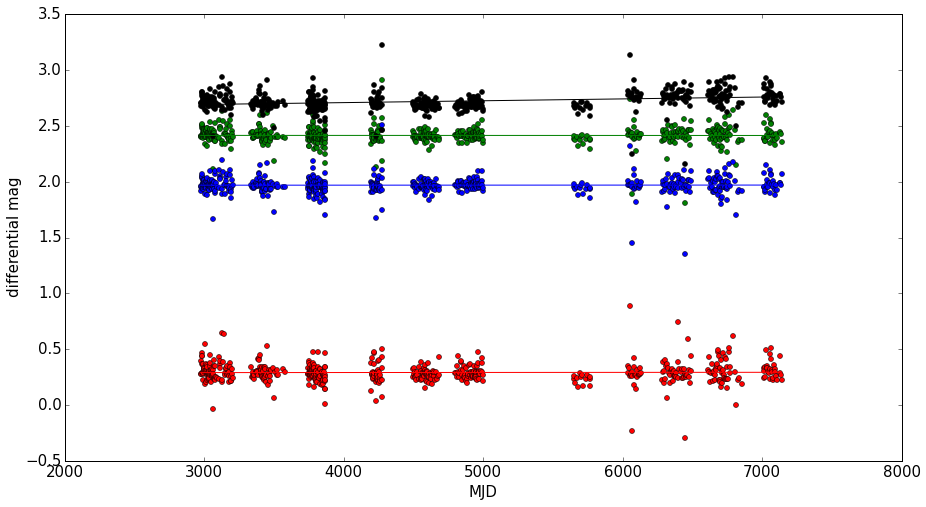

In [113]:
regVmag3=linear_model.LinearRegression()
regVmag4=linear_model.LinearRegression()
regVmag5=linear_model.LinearRegression()
regVmag8=linear_model.LinearRegression()

regVmag3.fit(photVTable['juliandate'].values.reshape(-1,1),(photVTable['mag1']-photVTable['mag3']).values.reshape(-1,1))
regVmag4.fit(photVTable['juliandate'].values.reshape(-1,1),(photVTable['mag1']-photVTable['mag4']).values.reshape(-1,1))
regVmag5.fit(photVTable['juliandate'].values.reshape(-1,1),(photVTable['mag1']-photVTable['mag5']).values.reshape(-1,1))
regVmag8.fit(photVTable['juliandate'].values.reshape(-1,1),(photVTable['mag1']-photVTable['mag8']).values.reshape(-1,1))

fig=plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)

ax.plot(photVTable['juliandate'].values.astype(float)-2450000,photVTable['mag1']-photVTable['mag3'],'go',ms=5)
ax.plot(photVTable['juliandate'].values.astype(float)-2450000,photVTable['mag1']-photVTable['mag4'],'bo',ms=5)
ax.plot(photVTable['juliandate'].values.astype(float)-2450000,photVTable['mag1']-photVTable['mag5'],'ro',ms=5)
ax.plot(photVTable['juliandate'].values.astype(float)-2450000,photVTable['mag1']-photVTable['mag8'],'ko',ms=5)

ax.plot(photVTable['juliandate'].values.astype(float)-2450000,regVmag3.predict(photVTable['juliandate'].values.reshape(-1,1).astype(float)),color='green')
ax.plot(photVTable['juliandate'].values.astype(float)-2450000,regVmag4.predict(photVTable['juliandate'].values.reshape(-1,1).astype(float)),color='blue')
ax.plot(photVTable['juliandate'].values.astype(float)-2450000,regVmag5.predict(photVTable['juliandate'].values.reshape(-1,1).astype(float)),color='red')
ax.plot(photVTable['juliandate'].values.astype(float)-2450000,regVmag8.predict(photVTable['juliandate'].values.reshape(-1,1).astype(float)),color='black')

ax.set_xlabel('MJD')
ax.set_ylabel('differential mag')

for i in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    i.set_fontsize(15)

plt.show()

In [114]:
[regVmag3.coef_*365, regVmag4.coef_*365, regVmag5.coef_*365, regVmag8.coef_*365]

[array([[ -6.12346818e-05]]),
 array([[ 0.00010144]]),
 array([[ 0.00023846]]),
 array([[ 0.006079]])]

# Find True Magnitudes
use the zero points and the instrumental magnitudes we calculated from stars in the Nova Musca field to calculate their true magnitudes

In [18]:
#grab the Iband photometry table, Vband photometry table, and the zeropoints table

suzpts=pd.read_pickle('suzpts')
zpts=pd.read_pickle('zptsTable')
photVTable=pd.read_pickle('photVTable')
photITable=pd.read_pickle('photITable')

In [19]:
masterV=pd.merge(pd.concat([suzpts,zpts]).ix[:,['date','star','v','cv','xv']],photVTable, on='date')
#the extinction coef for V was .14 before 200905 and .144 after
def excoefV(date):
    if date < 90500:
        return .14
    else:
        return .144
masterV['excoefV']=masterV['date'].apply(lambda x: excoefV(x))
photCalV=masterV.ix[:,['date','juliandate']].join(
    masterV.ix[:,['mag1','mag2','mag3','mag4','mag5',
                  'mag6','mag7','mag8','mag9','mag10']].apply(
        lambda x: x - masterV['cv'] - (masterV['airmass']*masterV['excoefV']), axis=0))
#photCalV.to_csv('photCalV.csv')

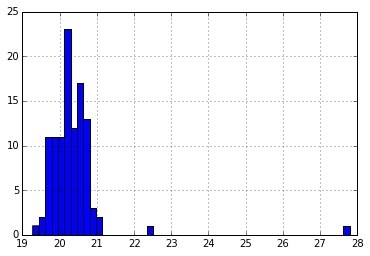

In [20]:
calib=masterV['mag1'] - masterV['cv'] - (masterV['airmass']*masterV['excoefV'])
calib.hist(bins=50)

In [36]:
print calib.mean(), calib.std(), calib.median()

19.1305049412 0.0855197389579 19.1294


In [21]:
masterI=pd.merge(pd.concat([suzpts,zpts]).ix[:,['date','star','i','ci','xi']],photITable, on='date')
#the extinction coef for V was .066 before 200905 and .056 after
def excoefI(date):
    if date < 90500:
        return .066
    else:
        return .056
masterI['excoefI']=masterI['date'].apply(lambda x: excoefI(x))
photCalI=masterI.ix[:,['date','juliandate']].join(
    masterI.ix[:,['mag1','mag2','mag3','mag4','mag5',
                  'mag6','mag7','mag8','mag9','mag10']].apply(
        lambda x: x - masterI['ci'] - (masterI['airmass']*masterI['excoefI']), axis=0))
#photCalI.to_csv('photCalI.csv')

In [22]:
masterV

,date,star,v,cv,xv,airmass,fname,juliandate,mag1,mag10,...,merr10,merr2,merr3,merr4,merr5,merr6,merr7,merr8,merr9,excoefV
0,80713,pg1657,2.64100,2.650000,0.007000,1.49,rccd080713.0013_gregist,2454661.49866,23.432,17.500,...,0.019,NaN,0.003,0.005,0.022,0.018,0.018,0.003,0.003,0.140
1,60109,RU149,2.91000,2.909000,0.030000,1.32,rccd060109.0081_gregist,2453745.81161,23.756,19.183,...,0.001,NaN,0.002,0.003,0.012,0.001,0.001,0.002,0.002,0.140
2,60110,RU149,3.58700,3.592000,0.016000,1.31,rccd060110.0083_gregist,2453746.81446,23.368,19.189,...,0.001,NaN,0.002,0.003,0.011,0.001,0.001,0.002,0.002,0.140
3,60111,RU149,2.86200,2.862000,0.015000,1.31,rccd060111.0088_gregist,2453747.81217,23.641,18.987,...,0.001,NaN,0.003,0.005,0.018,NaN,0.002,0.003,0.002,0.140
4,60112,RU149,2.88800,2.878000,0.047000,1.38,rccd060112.0096_gregist,2453748.76314,24.054,19.044,...,0.002,NaN,0.004,0.006,0.026,0.001,0.003,0.003,0.004,0.140
5,60114,RU149,2.89800,2.891000,0.038000,1.30,rccd060114.0109_gregist,2453750.80725,23.567,19.068,...,0.002,NaN,0.005,0.007,0.030,0.001,0.002,0.004,0.004,0.140
6,60116,RU149,2.92100,2.916000,0.012000,1.28,rccd060116.0081_gregist,2453752.84580,23.819,19.051,...,0.002,NaN,0.004,0.006,0.028,NaN,0.002,0.003,0.003,0.140
7,60117,RU149,2.92800,2.925000,0.016000,1.44,rccd060117.0079_gregist,2453753.72606,23.940,19.110,...,0.002,0.001,0.004,0.006,0.024,0.001,0.003,0.003,0.003,0.140
8,60118,RU149,2.93600,2.934000,0.041000,1.30,rccd060118.0103_gregist,2453754.80033,23.495,19.109,...,0.002,NaN,0.004,0.006,0.024,0.001,0.002,0.003,0.003,0.140
9,60121,RU149,3.24600,NaN,NaN,1.29,rccd060121.0104_gregist,2453757.81530,24.209,19.175,...,0.002,NaN,0.003,0.005,0.021,0.001,0.002,0.003,0.003,0.140


In [9]:
len(photITable)

579